# Pre Model Runs

## Packages

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl


import functools
import math
import numpy as np
import os
import pandas as pd
import PIL
from PIL import Image
import sys
import tensorflow as tf
import tensorflow_probability as tfp
import time


# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# Ensure matplotlib images are formatted in an easy to analyze format
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

## Model Functions

In [16]:
# turns a tensorflow object back into a photo
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# loads images from the google folders
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

# prints the image
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

# Function to load images into a NumPy array
def load_images_from_drive(folder_path, save_sizes = False):
    images = []
    image_sizes = []
    file_names = os.listdir(folder_path)

    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        img = Image.open(file_path)
        image_sizes.append(img.size)
        # Convert BGR to RGB (OpenCV loads images in BGR format)
        img_resized = img.resize((224,224), Image.ANTIALIAS)
        images.append(img_resized)
    if save_sizes == True:
        return np.array(images), image_sizes
    else:
        return np.array(images)

# Turns image into dataset
def image_to_dataset(array):
  x_data= np.ndarray(shape = (len(array), 224,224,3), dtype = np.float64)
  for i in range(0, len(array)):
      x = tf.keras.utils.img_to_array(array[i])
      x_data[i] = x
  x_data = x_data.astype('float32') / 255
  return x_data

#Picks the right model
def model_layers(layer_names, pretrained_model = 'VGG'):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  if pretrained_model == 'VGG':
    pretrained_model = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
  elif pretrained_model == 'ResNet':
    pretrained_model = tf.keras.applications.ResNet101(include_top=False, weights='imagenet')
  elif pretrained_model == 'Inception':
    pretrained_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet')
  elif pretrained_model == 'MobileNet':
    pretrained_model = tf.keras.applications.MobileNetV3Large(include_top=False, weights='imagenet')
  else:
    'Please select from the following models: VGG, ResNet, Inception, MobileNet.'

  outputs = [pretrained_model.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([pretrained_model.input], outputs)
  return model

# Picks the layers for style and content loss based on the model
def loss_layers(pretrained_model = 'VGG'):

    # VGG Layers
    if pretrained_model == 'VGG':
        content_layers = ['block5_conv2']

        style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1',
                    'block4_conv1',
                    'block5_conv1']

    # ResNet Layers
    elif pretrained_model == 'ResNet':
        content_layers = ['conv4_block12_2_relu']

        style_layers = ['conv1_relu',
                          'conv2_block1_1_relu',
                          'conv3_block1_1_relu',
                          'conv4_block1_1_relu',
                          'conv5_block1_1_relu']

    # Inception Layers
    elif pretrained_model == 'Inception':
        content_layers = ['mixed8']

        style_layers = ['mixed1',
                          'mixed2',
                          'mixed3',
                          'mixed4',
                          'mixed5']

    #MobileNet Layers
    else:
        content_layers = ['expanded_conv_14/expand']

        style_layers = ['expanded_conv_3/expand',
                          'expanded_conv_6/expand',
                          'expanded_conv_9/expand']

    return content_layers, style_layers


# Model Optimizer
def model_optimizer(optimizer_choice):
  if optimizer_choice == 'Adam':
    return tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
  elif optimizer_choice == 'SGD':
    return tf.keras.optimizers.experimental.SGD(learning_rate=0.02)
  elif optimizer_choice == 'RMSProp':
    return tf.keras.optimizers.experimental.RMSprop(learning_rate=0.02)
  else:
    print('This optimizer is not available, please pick between Adam, SGD, or RSMProp.')

# Gram Matrix used to compute the style loss
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

# Creates class to save the information to run and tune the model
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers, pretrained_model = 'VGG'):
    super(StyleContentModel, self).__init__()
    self.vgg = model_layers(style_layers + content_layers, pretrained_model = pretrained_model)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}


# Computes the content loss
def content_loss(content_image, content_targets):
    content_outputs = model(content_image)['content']
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    return content_loss

# Computes the style loss for 1 image
def style_loss_single(style_image, content_image, style_weight=1e-2):
    style_targets = model(content_image)['style']
    style_outputs = model(style_image)['style']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss  *= style_weight / 5
    return style_loss

# Computes the style loss for a list of images
def style_combined(content_image, style_dataset, log = False, exp_weight = 1, style_weight=1e-2):
    style_loss_record = []
    if log == True:
        for i in range(len(style_dataset)):
          style_loss_record.append(tf.math.log(style_loss_single(style_dataset[i], content_image, style_weight = style_weight)))
        style_score_combo = (tf.math.exp(sum(style_loss_record) * style_weight / len(style_loss_record) ))
        return style_score_combo
    else:
        for i in range(len(style_dataset)):
            style_loss_record.append(style_loss_single(style_dataset[i], content_image, style_weight = style_weight) ** exp_weight)
        style_score_combo = ((sum(style_loss_record)/ len(style_loss_record) ) ** (1 / exp_weight))
        return style_score_combo

# Returns which style image has the lowest loss to determine which image it's diverging towards to the most
def lowest_style_loss(content_image, style_dataset, log = False, exp_weight = 1, style_weight=1e-2):
    lowest_loss = float('inf')
    closest_image_num = -5
    if log == True:
        for i in range(len(style_dataset)):
          current_loss = tf.math.log(style_loss_single(style_dataset[i], content_image, style_weight = style_weight))
          if current_loss < lowest_loss:
            closest_image_num = i
            lowest_loss = current_loss
        return closest_image_num
    else:
        for i in range(len(style_dataset)):
            current_loss = style_loss_single(style_dataset[i], content_image, style_weight = style_weight) ** exp_weight
            if current_loss < lowest_loss:
              closest_image_num = i
              lowest_loss = current_loss
        return closest_image_num

# Computes the total loss for a model
def style_content_loss(outputs, content_image, content_targets, style_dataset, log = False, exp_weight = 1, style_weight = 1e-2, content_weight=1e4):
    style_loss = style_combined(content_image, style_dataset, log = log, exp_weight = exp_weight, style_weight = style_weight)
    content_outputs = outputs['content']
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])

    content_loss *= content_weight / 1
    loss = style_loss + content_loss
    return tf.cast(loss, tf.float32), tf.cast(style_loss, tf.float32), tf.cast(content_loss, tf.float32)

# Does 1 epoch of loss and backpropogation
@tf.function()
def training_round(content_image, style_dataset, content_targets, log = False, exp_weight = 1):
  with tf.GradientTape() as tape:
    outputs = model(content_image)
    loss, style_loss, content_loss = style_content_loss(outputs = outputs, content_image = content_image, content_targets = content_targets, style_dataset = style_dataset, log = log, exp_weight = exp_weight)
  grad = tape.gradient(loss, content_image)
  opt.apply_gradients([(grad, content_image)])
  content_image.assign(tf.clip_by_value(content_image, clip_value_min=0.0, clip_value_max=1.0))
  return content_image, loss, style_loss, content_loss

# Full model tuning
def train_network(content_image, style_dataset, content_layers, style_layers, training = True, pretrained_model = 'VGG', log = False, exp_weight = 1, epochs = 10):
  content_image = tf.image.resize(content_image, (224, 224))

  style_targets = model(style_dataset[0])['style']
  content_targets = model(content_image)['content']

  image = tf.Variable(content_image)

  # Saves the model loss for hyperparameter choices
  if training == True:
    columns = ["total_loss", "style_loss", "content_loss"]
    loss_average = pd.DataFrame(np.zeros((epochs, len(columns))), columns=columns)

  for epoch in range(epochs):
    content_image, loss, style_loss, content_loss = training_round(content_image = image, content_targets = content_targets, style_dataset = style_dataset, log = log, exp_weight = exp_weight)
    if training == True:
      loss_average.loc[epoch, ["total_loss", "style_loss", "content_loss"]] = [loss, style_loss, content_loss]
    #print('Epoch:' , str(epoch), '; Total Loss:', loss.numpy(), 'Style Loss:', str(style_loss.numpy()), '; Content Loss:', str(content_loss.numpy()))
  if training == True:
    return loss_average
  else:
    return content_image

## Datasets

In [17]:
# Dataset for the style images for each artist (first 30 photos only)
Andy_Warhol_Dataset = tf.cast(tf.convert_to_tensor(np.reshape(image_to_dataset(load_images_from_drive('/content/drive/MyDrive/Deep Learning/archive (6)/images/images/Andy_Warhol')), [-1, 1, 224,224, 3]), dtype=tf.float64), dtype=tf.float32)[:30]
Diego_Rivera_Dataset = tf.cast(tf.convert_to_tensor(np.reshape(image_to_dataset(load_images_from_drive('/content/drive/MyDrive/Deep Learning/archive (6)/images/images/Diego_Rivera')), [-1, 1, 224,224, 3]), dtype=tf.float64), dtype=tf.float32)[:30]
Marc_Chagall_Dataset = tf.cast(tf.convert_to_tensor(np.reshape(image_to_dataset(load_images_from_drive('/content/drive/MyDrive/Deep Learning/archive (6)/images/images/Marc_Chagall')), [-1, 1, 224,224, 3]), dtype=tf.float64), dtype=tf.float32)[:30]
Salvador_Dali_Dataset = tf.cast(tf.convert_to_tensor(np.reshape(image_to_dataset(load_images_from_drive('/content/drive/MyDrive/Deep Learning/archive (6)/images/images/Salvador_Dali')), [-1, 1, 224,224, 3]), dtype=tf.float64), dtype=tf.float32)[:30]
Pablo_Picasso_Dataset = tf.cast(tf.convert_to_tensor(np.reshape(image_to_dataset(load_images_from_drive('/content/drive/MyDrive/Deep Learning/archive (6)/images/images/Pablo_Picasso')), [-1, 1, 224,224, 3]), dtype=tf.float64), dtype=tf.float32)[:30]
Claude_Monet_Dataset = tf.cast(tf.convert_to_tensor(np.reshape(image_to_dataset(load_images_from_drive('/content/drive/MyDrive/Deep Learning/archive (6)/images/images/Claude_Monet')), [-1, 1, 224,224, 3]), dtype=tf.float64), dtype=tf.float32)[:30]

# Aggregation of the datasets for training
Training_Style_Datasets = [Andy_Warhol_Dataset, Diego_Rivera_Dataset, Marc_Chagall_Dataset, Salvador_Dali_Dataset, Pablo_Picasso_Dataset, Claude_Monet_Dataset]

# Training images for testing
Training_Content_Images = tf.cast(tf.convert_to_tensor(np.reshape(image_to_dataset(load_images_from_drive('/content/drive/MyDrive/Deep Learning/archive (6)/images/images/Training_Images')), [-1, 1, 224,224, 3]), dtype=tf.float64), dtype=tf.float32)

# Test images for additional examples
Test_Content_Images, test_image_sizes = load_images_from_drive('/content/drive/MyDrive/Deep Learning/archive (6)/images/images/Test_Images', save_sizes = True)
Test_Content_Images = tf.cast(tf.convert_to_tensor(np.reshape(image_to_dataset(Test_Content_Images), [-1, 1, 224,224, 3]), dtype=tf.float64), dtype=tf.float32)


<ipython-input-16-6d697e56a5bb>:47: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize((224,224), Image.ANTIALIAS)
<ipython-input-16-6d697e56a5bb>:52: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(images)
<ipython-input-16-6d697e56a5bb>:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify '

# Training Models

## VGG

### VGG - Normal

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


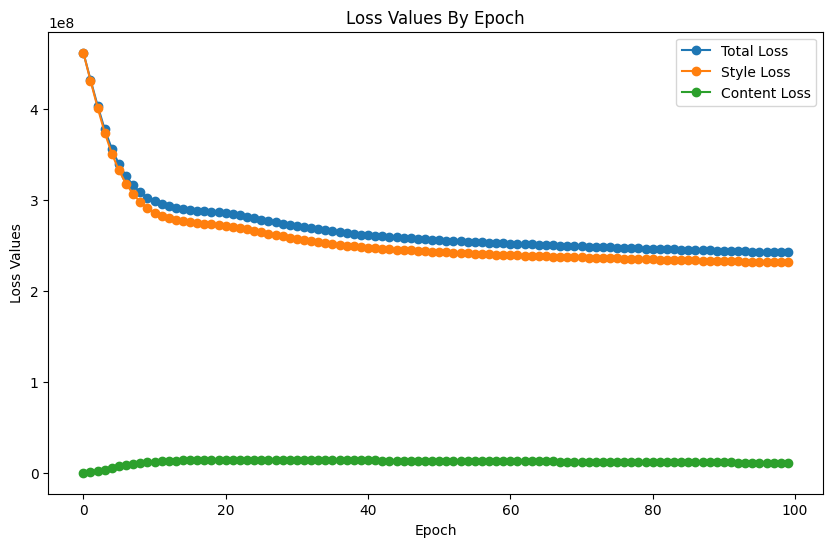

In [ ]:
# Hyperparameters
pretrained_model = 'VGG'
optimizer = 'Adam'
log = False
exp_weight = 1
epochs = 100


#Layer Information/Hyperparameters
content_layers, style_layers = loss_layers(pretrained_model = pretrained_model)

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

columns = ["total_loss", "style_loss", "content_loss"]
#loss_average = pd.DataFrame(np.zeros((epochs, len(columns))), columns=columns)

loss_average = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_vgg.csv')

test_runs = 0
for content_image in Training_Content_Images:
  for style_dataset in Training_Style_Datasets:
      test_runs += 1
      print(test_runs)
      if test_runs < 47:
        continue
      #Hyperparameters
      model = StyleContentModel(style_layers = style_layers, content_layers = content_layers, pretrained_model = pretrained_model)
      opt = model_optimizer(optimizer)
      image_loss = train_network(content_image = content_image, style_dataset = style_dataset, content_layers = content_layers, style_layers = style_layers, epochs = epochs, pretrained_model = pretrained_model, exp_weight = exp_weight, log = log)
      loss_add = pd.concat([loss_average, image_loss], axis = 1)
      loss_average['total_loss'] = loss_add['total_loss'].sum(axis = 1)
      loss_average['style_loss'] = loss_add['style_loss'].sum(axis = 1)
      loss_average['content_loss'] = loss_add['content_loss'].sum(axis = 1)
      loss_average.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_vgg.csv')
  # create for other 3 models
  # modify with variational loss

loss_vgg = loss_average.div(test_runs)
loss_vgg.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_vgg.csv')

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(loss_vgg.index, loss_vgg["total_loss"], label="Total Loss", marker='o')
plt.plot(loss_vgg.index, loss_vgg["style_loss"], label="Style Loss", marker='o')
plt.plot(loss_vgg.index, loss_vgg["content_loss"], label="Content Loss", marker='o')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss Values")
plt.title("Loss Values By Epoch")

# Add legend
plt.legend()

# Show the plot
plt.show()

### VGG - Squared

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


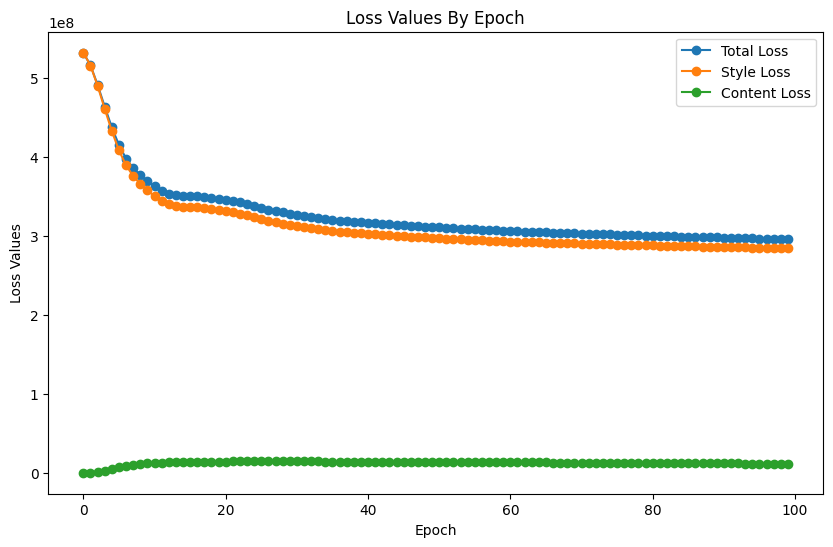

In [ ]:
# Hyperparameters
pretrained_model = 'VGG'
optimizer = 'Adam'
log = False
exp_weight = 2
epochs = 100

#Layer Information/Hyperparameters
content_layers, style_layers = loss_layers(pretrained_model = pretrained_model)

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

columns = ["total_loss", "style_loss", "content_loss"]

loss_average = pd.DataFrame(np.zeros((epochs, len(columns))), columns=columns)

#loss_average = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_vgg_sq.csv')

test_runs = 0
for content_image in Training_Content_Images:
  for style_dataset in Training_Style_Datasets:
      test_runs += 1
      print(test_runs)
      if test_runs < 0:
        continue
      #Hyperparameters
      model = StyleContentModel(style_layers = style_layers, content_layers = content_layers, pretrained_model = pretrained_model)
      opt = model_optimizer(optimizer)
      image_loss = train_network(content_image = content_image, style_dataset = style_dataset, content_layers = content_layers, style_layers = style_layers, epochs = epochs, pretrained_model = pretrained_model, exp_weight = exp_weight, log = log)
      loss_add = pd.concat([loss_average, image_loss], axis = 1)
      loss_average['total_loss'] = loss_add['total_loss'].sum(axis = 1)
      loss_average['style_loss'] = loss_add['style_loss'].sum(axis = 1)
      loss_average['content_loss'] = loss_add['content_loss'].sum(axis = 1)
      loss_average.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_vgg_sq.csv')

loss_vgg_sq = loss_average.div(test_runs)
closs_vgg_sq.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_vgg_sq.csv')

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(loss_vgg_sq.index, loss_vgg_sq["total_loss"], label="Total Loss", marker='o')
plt.plot(loss_vgg_sq.index, loss_vgg_sq["style_loss"], label="Style Loss", marker='o')
plt.plot(loss_vgg_sq.index, loss_vgg_sq["content_loss"], label="Content Loss", marker='o')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss Values")
plt.title("Loss Values By Epoch")

# Add legend
plt.legend()

# Show the plot
plt.show()

### VGG - Log

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


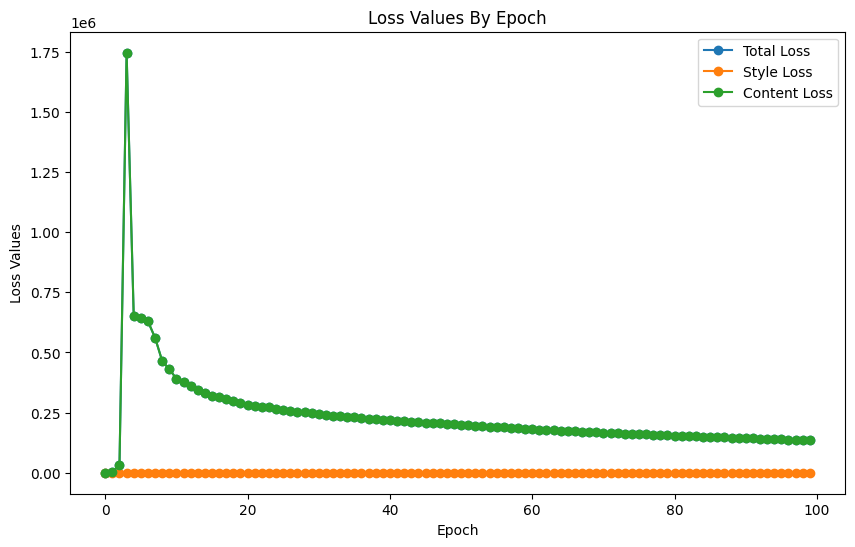

In [ ]:
# Hyperparameters
pretrained_model = 'VGG'
optimizer = 'Adam'
log = True
exp_weight = 1
epochs = 100

#Layer Information/Hyperparameters
content_layers, style_layers = loss_layers(pretrained_model = pretrained_model)

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

columns = ["total_loss", "style_loss", "content_loss"]
loss_average = pd.DataFrame(np.zeros((epochs, len(columns))), columns=columns)

#loss_average = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_vgg_log.csv')

test_runs = 0
for content_image in Training_Content_Images:
  for style_dataset in Training_Style_Datasets:
      test_runs += 1
      print(test_runs)
      if test_runs < 0:
        continue
      #Hyperparameters
      model = StyleContentModel(style_layers = style_layers, content_layers = content_layers, pretrained_model = pretrained_model)
      opt = model_optimizer(optimizer)
      image_loss = train_network(content_image = content_image, style_dataset = style_dataset, content_layers = content_layers, style_layers = style_layers, epochs = epochs, pretrained_model = pretrained_model, exp_weight = exp_weight, log = log)
      loss_add = pd.concat([loss_average, image_loss], axis = 1)
      loss_average['total_loss'] = loss_add['total_loss'].sum(axis = 1)
      loss_average['style_loss'] = loss_add['style_loss'].sum(axis = 1)
      loss_average['content_loss'] = loss_add['content_loss'].sum(axis = 1)
      loss_average.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_vgg_log.csv')

loss_vgg_log = loss_average.div(10)
loss_vgg_log.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_vgg_log.csv')

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(loss_vgg_log.index, loss_vgg_log["total_loss"], label="Total Loss", marker='o')
plt.plot(loss_vgg_log.index, loss_vgg_log["style_loss"], label="Style Loss", marker='o')
plt.plot(loss_vgg_log.index, loss_vgg_log["content_loss"], label="Content Loss", marker='o')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss Values")
plt.title("Loss Values By Epoch")

# Add legend
plt.legend()

# Show the plot
plt.show()

## ResNet

### ResNet

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


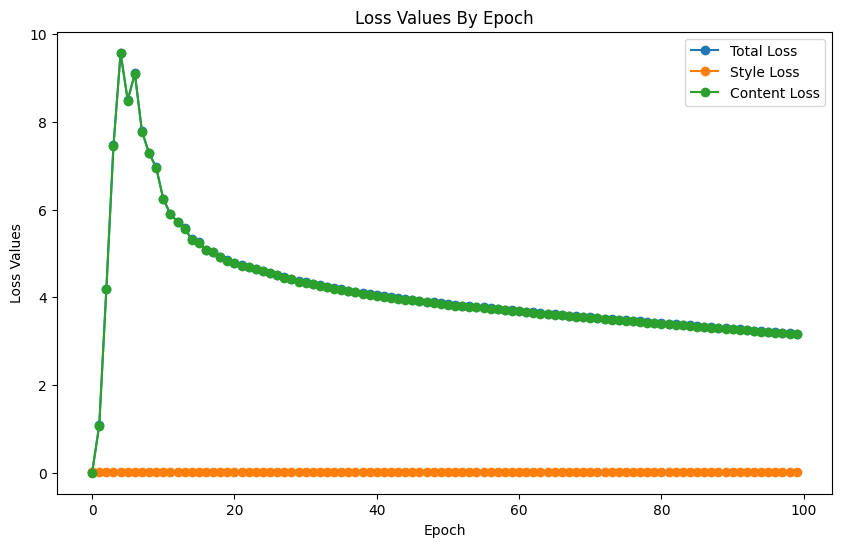

In [ ]:
# Hyperparameters
pretrained_model = 'ResNet'
optimizer = 'Adam'
log = False
exp_weight = 1
epochs = 100

#Layer Information/Hyperparameters
content_layers, style_layers = loss_layers(pretrained_model = pretrained_model)

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

columns = ["total_loss", "style_loss", "content_loss"]
loss_average = pd.DataFrame(np.zeros((epochs, len(columns))), columns=columns)

#loss_average = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_resnet.csv')

test_runs = 0
for content_image in Training_Content_Images:
  for style_dataset in Training_Style_Datasets:
      test_runs += 1
      print(test_runs)
      if test_runs < 0:
        continue
      #Hyperparameters
      model = StyleContentModel(style_layers = style_layers, content_layers = content_layers, pretrained_model = pretrained_model)
      opt = model_optimizer(optimizer)
      image_loss = train_network(content_image = content_image, style_dataset = style_dataset, content_layers = content_layers, style_layers = style_layers, epochs = epochs, pretrained_model = pretrained_model, exp_weight = exp_weight, log = log)
      loss_add = pd.concat([loss_average, image_loss], axis = 1)
      loss_average['total_loss'] = loss_add['total_loss'].sum(axis = 1)
      loss_average['style_loss'] = loss_add['style_loss'].sum(axis = 1)
      loss_average['content_loss'] = loss_add['content_loss'].sum(axis = 1)
      loss_average.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_resnet.csv')

loss_resnet = loss_average.div(test_runs)
loss_resnet.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_resnet.csv')

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(loss_resnet.index, loss_resnet["total_loss"], label="Total Loss", marker='o')
plt.plot(loss_resnet.index, loss_resnet["style_loss"], label="Style Loss", marker='o')
plt.plot(loss_resnet.index, loss_resnet["content_loss"], label="Content Loss", marker='o')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss Values")
plt.title("Loss Values By Epoch")

# Add legend
plt.legend()

# Show the plot
plt.show()

### ResNet - Squared

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


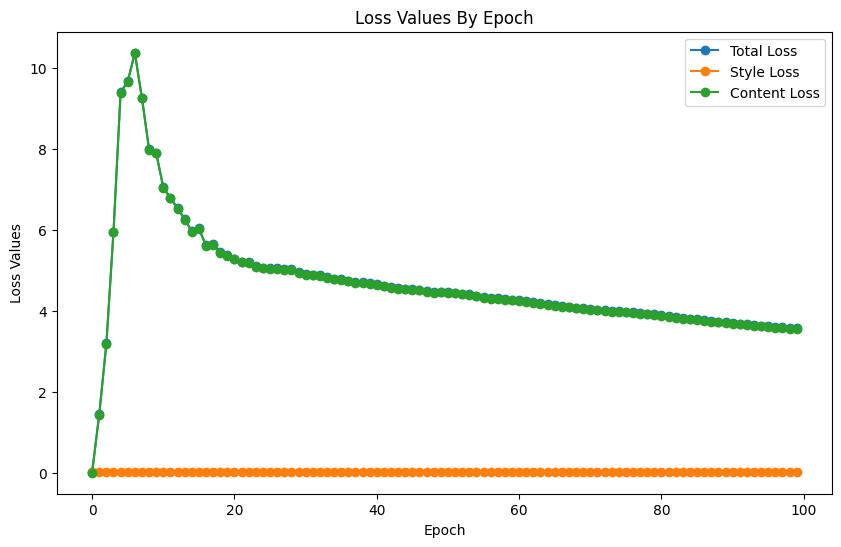

In [ ]:
# Hyperparameters
pretrained_model = 'ResNet'
optimizer = 'Adam'
log = False
exp_weight = 2
epochs = 100

#Layer Information/Hyperparameters
content_layers, style_layers = loss_layers(pretrained_model = pretrained_model)

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

columns = ["total_loss", "style_loss", "content_loss"]
loss_average = pd.DataFrame(np.zeros((epochs, len(columns))), columns=columns)

#loss_average = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_resnet_sq.csv')

test_runs = 0
for content_image in Training_Content_Images:
  for style_dataset in Training_Style_Datasets:
      test_runs += 1
      print(test_runs)
      if test_runs < 0:
        continue
      #Hyperparameters
      model = StyleContentModel(style_layers = style_layers, content_layers = content_layers, pretrained_model = pretrained_model)
      opt = model_optimizer(optimizer)
      image_loss = train_network(content_image = content_image, style_dataset = style_dataset, content_layers = content_layers, style_layers = style_layers, epochs = epochs, pretrained_model = pretrained_model, exp_weight = exp_weight, log = log)
      loss_add = pd.concat([loss_average, image_loss], axis = 1)
      loss_average['total_loss'] = loss_add['total_loss'].sum(axis = 1)
      loss_average['style_loss'] = loss_add['style_loss'].sum(axis = 1)
      loss_average['content_loss'] = loss_add['content_loss'].sum(axis = 1)
      loss_average.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_resnet_sq.csv')

loss_resnet_sq = loss_average.div(test_runs)
loss_resnet_sq.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_resnet_sq.csv')

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(loss_resnet_sq.index, loss_resnet_sq["total_loss"], label="Total Loss", marker='o')
plt.plot(loss_resnet_sq.index, loss_resnet_sq["style_loss"], label="Style Loss", marker='o')
plt.plot(loss_resnet_sq.index, loss_resnet_sq["content_loss"], label="Content Loss", marker='o')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss Values")
plt.title("Loss Values By Epoch")

# Add legend
plt.legend()

# Show the plot
plt.show()

### ResNet - Log

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


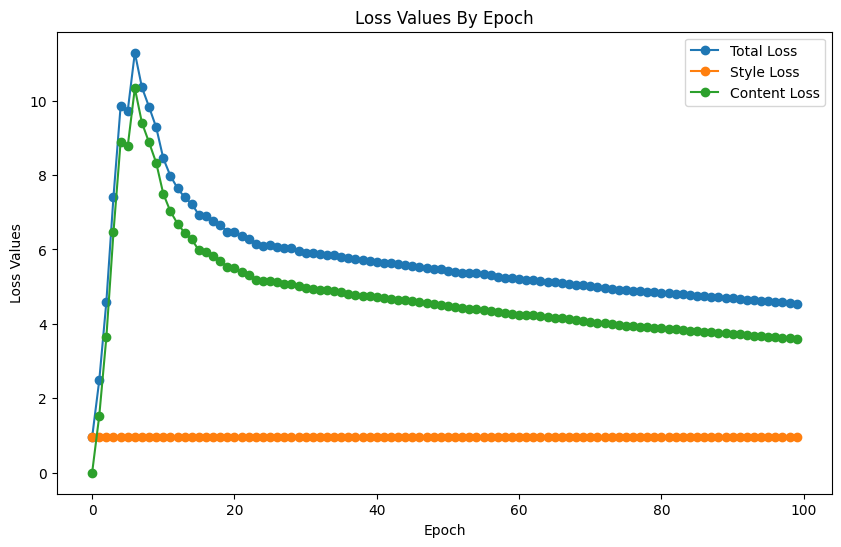

In [ ]:
# Hyperparameters
pretrained_model = 'ResNet'
optimizer = 'Adam'
log = True
exp_weight = 1
epochs = 100

#Layer Information/Hyperparameters
content_layers, style_layers = loss_layers(pretrained_model = pretrained_model)

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

columns = ["total_loss", "style_loss", "content_loss"]
loss_average = pd.DataFrame(np.zeros((epochs, len(columns))), columns=columns)

#loss_average = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_resnet_log.csv')

test_runs = 0
for content_image in Training_Content_Images:
  for style_dataset in Training_Style_Datasets:
      test_runs += 1
      print(test_runs)
      if test_runs < 0:
        continue
      #Hyperparameters
      model = StyleContentModel(style_layers = style_layers, content_layers = content_layers, pretrained_model = pretrained_model)
      opt = model_optimizer(optimizer)
      image_loss = train_network(content_image = content_image, style_dataset = style_dataset, content_layers = content_layers, style_layers = style_layers, epochs = epochs, pretrained_model = pretrained_model, exp_weight = exp_weight, log = log)
      loss_add = pd.concat([loss_average, image_loss], axis = 1)
      loss_average['total_loss'] = loss_add['total_loss'].sum(axis = 1)
      loss_average['style_loss'] = loss_add['style_loss'].sum(axis = 1)
      loss_average['content_loss'] = loss_add['content_loss'].sum(axis = 1)
      loss_average.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_resnet_log.csv')

loss_resnet_log = loss_average.div(test_runs)
loss_resnet_log.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_resnet_log.csv')

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(loss_resnet_log.index, loss_resnet_log["total_loss"], label="Total Loss", marker='o')
plt.plot(loss_resnet_log.index, loss_resnet_log["style_loss"], label="Style Loss", marker='o')
plt.plot(loss_resnet_log.index, loss_resnet_log["content_loss"], label="Content Loss", marker='o')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss Values")
plt.title("Loss Values By Epoch")

# Add legend
plt.legend()

# Show the plot
plt.show()

## Inception

### Inception

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


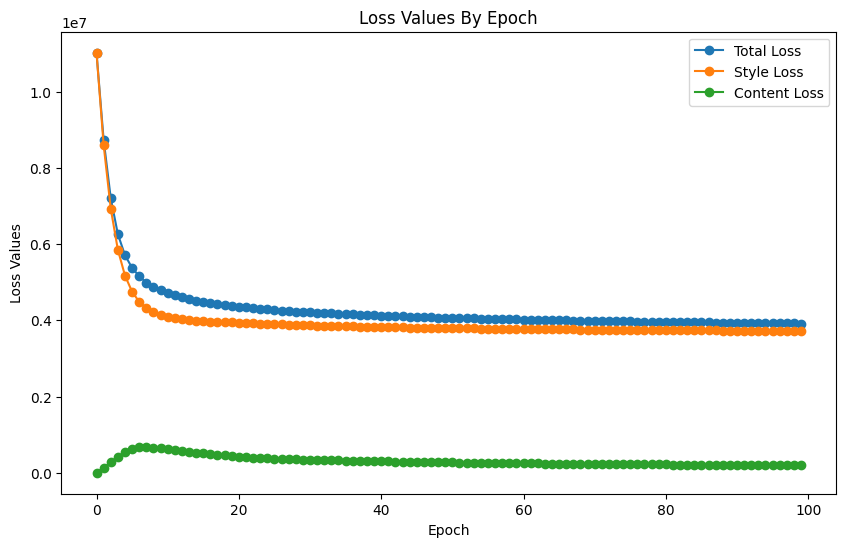

In [ ]:
# Hyperparameters
pretrained_model = 'Inception'
optimizer = 'Adam'
log = False
exp_weight = 1
epochs = 100

#Layer Information/Hyperparameters
content_layers, style_layers = loss_layers(pretrained_model = pretrained_model)

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

columns = ["total_loss", "style_loss", "content_loss"]
loss_average = pd.DataFrame(np.zeros((epochs, len(columns))), columns=columns)

#loss_average = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_inception.csv')

test_runs = 0
for content_image in Training_Content_Images:
  for style_dataset in Training_Style_Datasets:
      test_runs += 1
      print(test_runs)
      if test_runs < 0:
        continue
      #Hyperparameters
      model = StyleContentModel(style_layers = style_layers, content_layers = content_layers, pretrained_model = pretrained_model)
      opt = model_optimizer(optimizer)
      image_loss = train_network(content_image = content_image, style_dataset = style_dataset, content_layers = content_layers, style_layers = style_layers, epochs = epochs, pretrained_model = pretrained_model, exp_weight = exp_weight, log = log)
      loss_add = pd.concat([loss_average, image_loss], axis = 1)
      loss_average['total_loss'] = loss_add['total_loss'].sum(axis = 1)
      loss_average['style_loss'] = loss_add['style_loss'].sum(axis = 1)
      loss_average['content_loss'] = loss_add['content_loss'].sum(axis = 1)
      loss_average.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_inception.csv')

loss_Inception = loss_average.div(test_runs)
loss_Inception.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_inception.csv')

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(loss_Inception.index, loss_Inception["total_loss"], label="Total Loss", marker='o')
plt.plot(loss_Inception.index, loss_Inception["style_loss"], label="Style Loss", marker='o')
plt.plot(loss_Inception.index, loss_Inception["content_loss"], label="Content Loss", marker='o')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss Values")
plt.title("Loss Values By Epoch")

# Add legend
plt.legend()

# Show the plot
plt.show()

### Inception - Squared

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


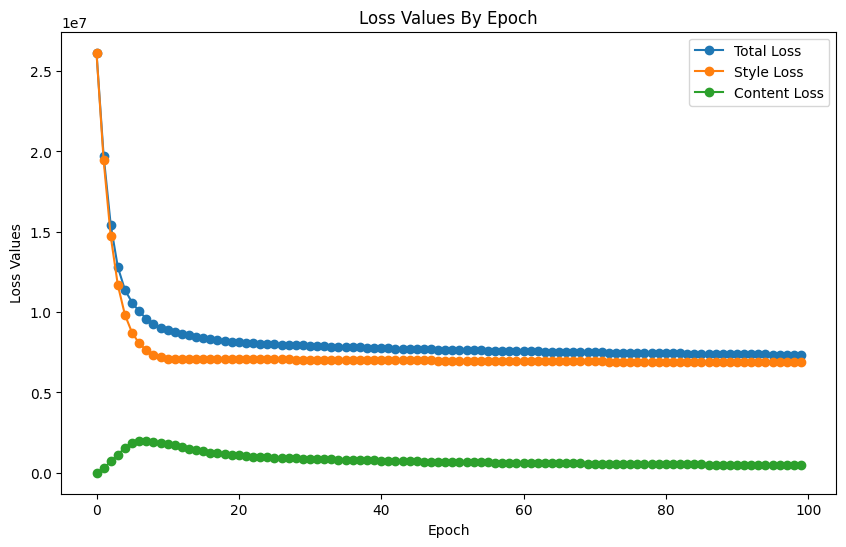

In [ ]:
# Hyperparameters
pretrained_model = 'Inception'
optimizer = 'Adam'
log = False
exp_weight = 2
epochs = 100

#Layer Information/Hyperparameters
content_layers, style_layers = loss_layers(pretrained_model = pretrained_model)

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

columns = ["total_loss", "style_loss", "content_loss"]
loss_average = pd.DataFrame(np.zeros((epochs, len(columns))), columns=columns)

#loss_average = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_inception_sq.csv')

test_runs = 0
for content_image in Training_Content_Images:
  for style_dataset in Training_Style_Datasets:
      test_runs += 1
      print(test_runs)
      if test_runs < 0:
        continue
      #Hyperparameters
      model = StyleContentModel(style_layers = style_layers, content_layers = content_layers, pretrained_model = pretrained_model)
      opt = model_optimizer(optimizer)
      image_loss = train_network(content_image = content_image, style_dataset = style_dataset, content_layers = content_layers, style_layers = style_layers, epochs = epochs, pretrained_model = pretrained_model, exp_weight = exp_weight, log = log)
      loss_add = pd.concat([loss_average, image_loss], axis = 1)
      loss_average['total_loss'] = loss_add['total_loss'].sum(axis = 1)
      loss_average['style_loss'] = loss_add['style_loss'].sum(axis = 1)
      loss_average['content_loss'] = loss_add['content_loss'].sum(axis = 1)
      loss_average.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_inception_sq.csv')

loss_inception_sq = loss_average.div(test_runs)
loss_inception_sq.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_inception_sq.csv')

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(loss_inception_sq.index, loss_inception_sq["total_loss"], label="Total Loss", marker='o')
plt.plot(loss_inception_sq.index, loss_inception_sq["style_loss"], label="Style Loss", marker='o')
plt.plot(loss_inception_sq.index, loss_inception_sq["content_loss"], label="Content Loss", marker='o')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss Values")
plt.title("Loss Values By Epoch")

# Add legend
plt.legend()

# Show the plot
plt.show()

### Inception - Log

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


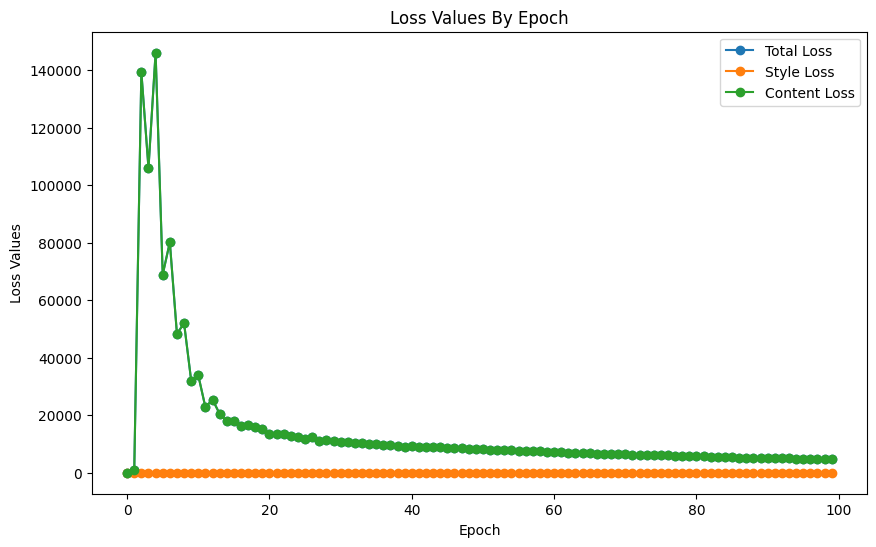

In [ ]:
# Hyperparameters
pretrained_model = 'Inception'
optimizer = 'Adam'
log = True
exp_weight = 1
epochs = 100

#Layer Information/Hyperparameters
content_layers, style_layers = loss_layers(pretrained_model = pretrained_model)

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

columns = ["total_loss", "style_loss", "content_loss"]
loss_average = pd.DataFrame(np.zeros((epochs, len(columns))), columns=columns)

#loss_average = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_inception_log.csv')

test_runs = 0
for content_image in Training_Content_Images:
  for style_dataset in Training_Style_Datasets:
      test_runs += 1
      print(test_runs)
      if test_runs < 0:
        continue
      #Hyperparameters
      model = StyleContentModel(style_layers = style_layers, content_layers = content_layers, pretrained_model = pretrained_model)
      opt = model_optimizer(optimizer)
      image_loss = train_network(content_image = content_image, style_dataset = style_dataset, content_layers = content_layers, style_layers = style_layers, epochs = epochs, pretrained_model = pretrained_model, exp_weight = exp_weight, log = log)
      loss_add = pd.concat([loss_average, image_loss], axis = 1)
      loss_average['total_loss'] = loss_add['total_loss'].sum(axis = 1)
      loss_average['style_loss'] = loss_add['style_loss'].sum(axis = 1)
      loss_average['content_loss'] = loss_add['content_loss'].sum(axis = 1)
      loss_average.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_inception_log.csv')

loss_inception_log = loss_average.div(test_runs)
loss_inception_log.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_inception_log.csv')

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(loss_inception_log.index, loss_inception_log["total_loss"], label="Total Loss", marker='o')
plt.plot(loss_inception_log.index, loss_inception_log["style_loss"], label="Style Loss", marker='o')
plt.plot(loss_inception_log.index, loss_inception_log["content_loss"], label="Content Loss", marker='o')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss Values")
plt.title("Loss Values By Epoch")

# Add legend
plt.legend()

# Show the plot
plt.show()

## MobileNet

### MobileNet

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


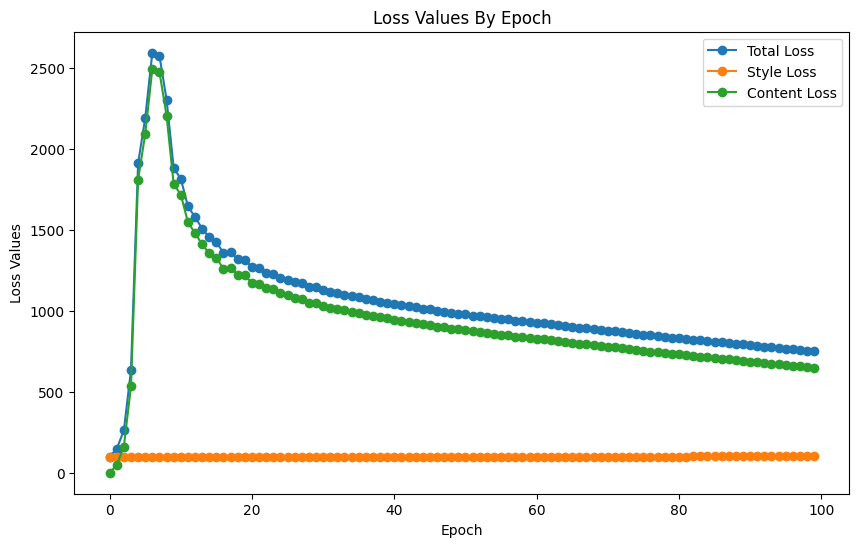

In [ ]:
# Hyperparameters
pretrained_model = 'MobileNet'
optimizer = 'Adam'
log = False
exp_weight = 1
epochs = 100

#Layer Information/Hyperparameters
content_layers, style_layers = loss_layers(pretrained_model = pretrained_model)

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

columns = ["total_loss", "style_loss", "content_loss"]
loss_average = pd.DataFrame(np.zeros((epochs, len(columns))), columns=columns)

#loss_average = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_mobilenet.csv')

test_runs = 0
for content_image in Training_Content_Images:
  for style_dataset in Training_Style_Datasets:
      test_runs += 1
      print(test_runs)
      if test_runs < 0:
        continue
      #Hyperparameters
      model = StyleContentModel(style_layers = style_layers, content_layers = content_layers, pretrained_model = pretrained_model)
      opt = model_optimizer(optimizer)
      image_loss = train_network(content_image = content_image, style_dataset = style_dataset, content_layers = content_layers, style_layers = style_layers, epochs = epochs, pretrained_model = pretrained_model, exp_weight = exp_weight, log = log)
      loss_add = pd.concat([loss_average, image_loss], axis = 1)
      loss_average['total_loss'] = loss_add['total_loss'].sum(axis = 1)
      loss_average['style_loss'] = loss_add['style_loss'].sum(axis = 1)
      loss_average['content_loss'] = loss_add['content_loss'].sum(axis = 1)
      loss_average.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_mobilenet.csv')
  # create for other 3 models
  # modify with variational loss

loss_mobilenet = loss_average.div(test_runs)
loss_mobilenet.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_mobilenet.csv')

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(loss_mobilenet.index, loss_mobilenet["total_loss"], label="Total Loss", marker='o')
plt.plot(loss_mobilenet.index, loss_mobilenet["style_loss"], label="Style Loss", marker='o')
plt.plot(loss_mobilenet.index, loss_mobilenet["content_loss"], label="Content Loss", marker='o')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss Values")
plt.title("Loss Values By Epoch")

# Add legend
plt.legend()

# Show the plot
plt.show()

### MobileNet - Squared

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


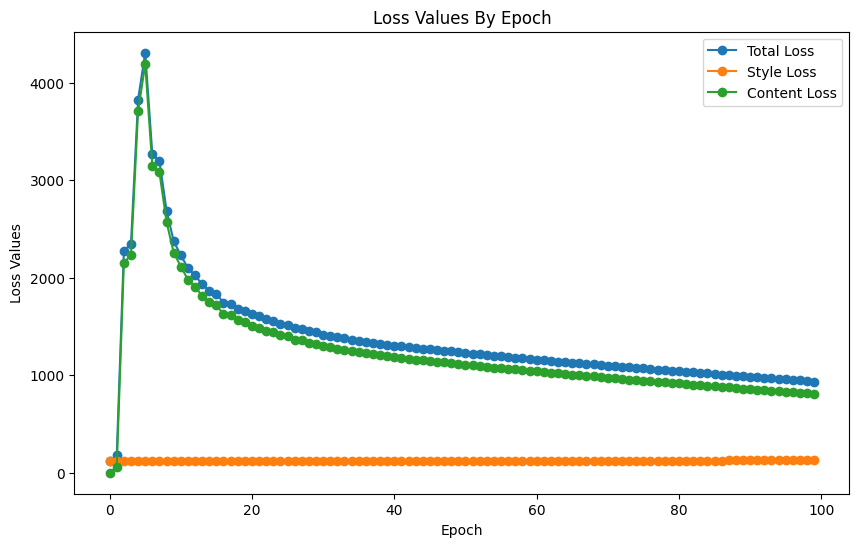

In [ ]:
# Hyperparameters
pretrained_model = 'MobileNet'
optimizer = 'Adam'
log = False
exp_weight = 2
epochs = 100

#Layer Information/Hyperparameters
content_layers, style_layers = loss_layers(pretrained_model = pretrained_model)

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

columns = ["total_loss", "style_loss", "content_loss"]
loss_average = pd.DataFrame(np.zeros((epochs, len(columns))), columns=columns)

#loss_average = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_mobilenet_sq.csv')

test_runs = 0
for content_image in Training_Content_Images:
  for style_dataset in Training_Style_Datasets:
      test_runs += 1
      print(test_runs)
      if test_runs < 0:
        continue
      #Hyperparameters
      model = StyleContentModel(style_layers = style_layers, content_layers = content_layers, pretrained_model = pretrained_model)
      opt = model_optimizer(optimizer)
      image_loss = train_network(content_image = content_image, style_dataset = style_dataset, content_layers = content_layers, style_layers = style_layers, epochs = epochs, pretrained_model = pretrained_model, exp_weight = exp_weight, log = log)
      loss_add = pd.concat([loss_average, image_loss], axis = 1)
      loss_average['total_loss'] = loss_add['total_loss'].sum(axis = 1)
      loss_average['style_loss'] = loss_add['style_loss'].sum(axis = 1)
      loss_average['content_loss'] = loss_add['content_loss'].sum(axis = 1)
      loss_average.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_mobilenet_sq.csv')
  # create for other 3 models
  # modify with variational loss

loss_mobilenet_sq = loss_average.div(test_runs)
loss_mobilenet_sq.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_mobilenet_sq.csv')

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(loss_mobilenet_sq.index, loss_mobilenet_sq["total_loss"], label="Total Loss", marker='o')
plt.plot(loss_mobilenet_sq.index, loss_mobilenet_sq["style_loss"], label="Style Loss", marker='o')
plt.plot(loss_mobilenet_sq.index, loss_mobilenet_sq["content_loss"], label="Content Loss", marker='o')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss Values")
plt.title("Loss Values By Epoch")

# Add legend
plt.legend()

# Show the plot
plt.show()

### MobileNet - Log

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


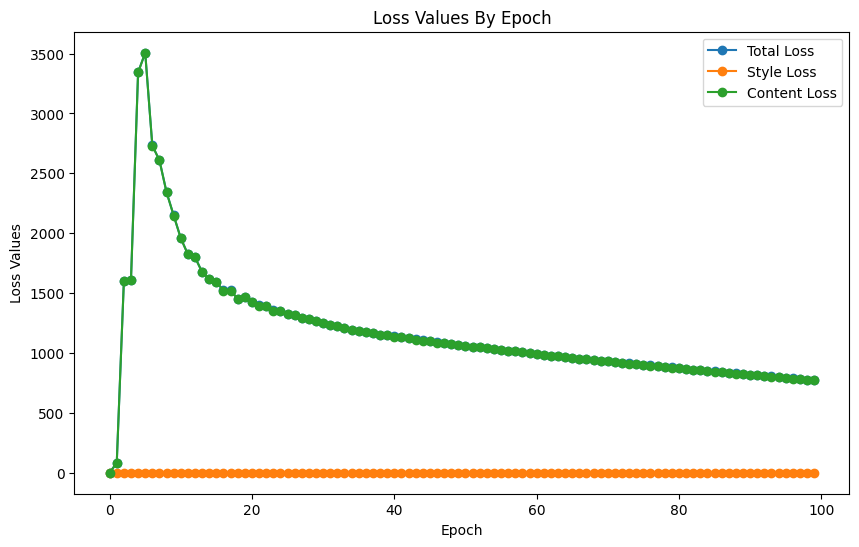

In [ ]:
# Hyperparameters
pretrained_model = 'MobileNet'
optimizer = 'Adam'
log = True
exp_weight = 1
epochs = 100

#Layer Information/Hyperparameters
content_layers, style_layers = loss_layers(pretrained_model = pretrained_model)

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

columns = ["total_loss", "style_loss", "content_loss"]
loss_average = pd.DataFrame(np.zeros((epochs, len(columns))), columns=columns)

#loss_average = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_mobilenet_log.csv')

test_runs = 0
for content_image in Training_Content_Images:
  for style_dataset in Training_Style_Datasets:
      test_runs += 1
      print(test_runs)
      if test_runs < 0:
        continue
      #Hyperparameters
      model = StyleContentModel(style_layers = style_layers, content_layers = content_layers, pretrained_model = pretrained_model)
      opt = model_optimizer(optimizer)
      image_loss = train_network(content_image = content_image, style_dataset = style_dataset, content_layers = content_layers, style_layers = style_layers, epochs = epochs, pretrained_model = pretrained_model, exp_weight = exp_weight, log = log)
      loss_add = pd.concat([loss_average, image_loss], axis = 1)
      loss_average['total_loss'] = loss_add['total_loss'].sum(axis = 1)
      loss_average['style_loss'] = loss_add['style_loss'].sum(axis = 1)
      loss_average['content_loss'] = loss_add['content_loss'].sum(axis = 1)
      loss_average.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_mobilenet_log.csv')
  # create for other 3 models
  # modify with variational loss

loss_mobilenet_log = loss_average.div(test_runs)
loss_mobilenet_log.to_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_mobilenet_log.csv')

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(loss_mobilenet_log.index, loss_mobilenet_log["total_loss"], label="Total Loss", marker='o')
plt.plot(loss_mobilenet_log.index, loss_mobilenet_log["style_loss"], label="Style Loss", marker='o')
plt.plot(loss_mobilenet_log.index, loss_mobilenet_log["content_loss"], label="Content Loss", marker='o')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss Values")
plt.title("Loss Values By Epoch")

# Add legend
plt.legend()

# Show the plot
plt.show()

# Test Analysis

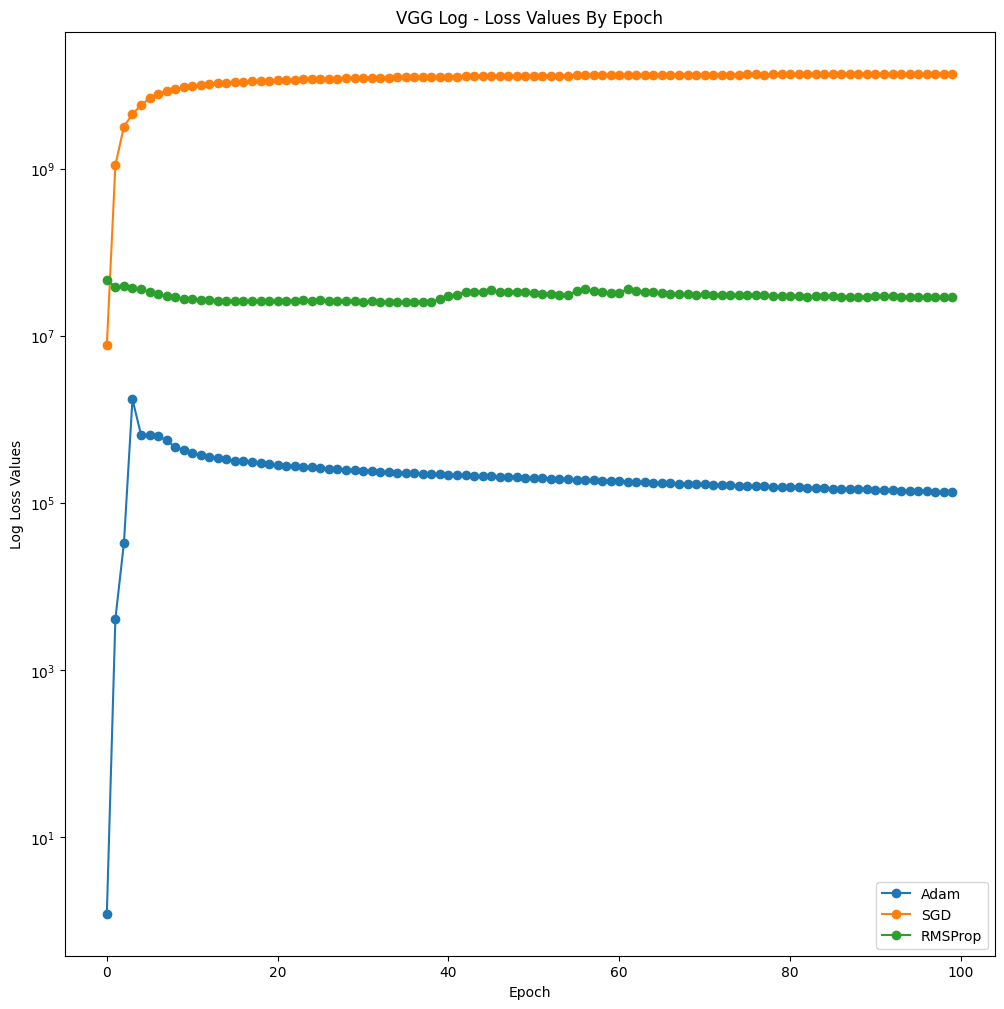

In [ ]:
#Use to compare different optimizer hyperparameter

Adam = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_vgg_log.csv')
SGD = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/SGD_loss_vgg_log.csv')
RMSProp = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/rmsprop_loss_vgg_log.csv')

plt.yscale('log')

plt.plot(Adam.index, Adam["total_loss"], label="Adam", marker='o')
plt.plot(SGD.index, SGD["total_loss"], label="SGD", marker='o')
plt.plot(RMSProp.index, RMSProp["total_loss"], label="RMSProp", marker='o')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Log Loss Values")
plt.title("VGG Log - Loss Values By Epoch")

# Add legend
plt.legend()

# Save the plot as an image file (e.g., PNG)
plt.savefig('/content/drive/MyDrive/Deep Learning/Optimizer Comparison - Images/VGG_log.png')

# Show the plot
plt.show()

In [ ]:
# Get the epoch when plateaus

def loss_plateau(loss_col, earlystop_threshold = -0.01):

  for i in range(len(loss_col)):
    if i == 0:
      prev_loss = loss_col[0]
    else:
      prev_loss = current_loss.copy()
    current_loss = loss_col[i]
    if ((current_loss - prev_loss) < 0) & (((current_loss - prev_loss)/ prev_loss) > earlystop_threshold):
      return i
  return len(loss_col)


VGG = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/rmsprop_loss_vgg.csv')
print('Stopping Epoch for VGG - ', loss_plateau(VGG['total_loss'], -0.001), '')

VGG_Squared = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/rmsprop_loss_vgg_sq.csv')
print('Stopping Epoch for VGG Squared - ', loss_plateau(VGG_Squared['total_loss'], -0.001), '')

VGG_Log = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_vgg_log.csv')
print('Stopping Epoch for VGG Log - ', loss_plateau(VGG_Log['total_loss'], -0.001), '')

ResNet = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_resnet.csv')
print('Stopping Epoch for ResNet - ', loss_plateau(ResNet['total_loss'], -0.001), '')

ResNet_Squared = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_resnet_sq.csv')
print('Stopping Epoch for ResNet Squared - ', loss_plateau(ResNet_Squared['total_loss'], -0.001), '')

ResNet_Log = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_resnet_log.csv')
print('Stopping Epoch for ResNet Log - ', loss_plateau(ResNet_Log['total_loss'], -0.001), '')

Inception = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_inception.csv')
print('Stopping Epoch for Inception - ', loss_plateau(Inception['total_loss'], -0.001), '')

Inception_Squared = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/rmsprop_loss_inception_sq.csv')
print('Stopping Epoch for Inception Squared - ', loss_plateau(Inception_Squared['total_loss'], -0.001), '')

Inception_Log = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_inception_log.csv')
print('Stopping Epoch for Inception Log - ', loss_plateau(Inception_Log['total_loss'], -0.001), '')

MobileNet = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_mobilenet.csv')
print('Stopping Epoch for MobileNet - ', loss_plateau(MobileNet['total_loss'], -0.001), '')

MobileNet_Squared = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_mobilenet_sq.csv')
print('Stopping Epoch for MobileNet Squared - ', loss_plateau(MobileNet_Squared['total_loss'], -0.001), '')

MobileNet_Log = pd.read_csv('/content/drive/MyDrive/Deep Learning/Training Loss Datasets/Adam_loss_mobilenet_log.csv')
print('Stopping Epoch for MobileNet Log - ', loss_plateau(MobileNet_Log['total_loss'], -0.001), '')

Stopping Epoch for VGG -  36 
Stopping Epoch for VGG Squared -  63 
Stopping Epoch for VGG Log -  100 
Stopping Epoch for ResNet -  100 
Stopping Epoch for ResNet Squared -  26 
Stopping Epoch for ResNet Log -  62 
Stopping Epoch for Inception -  59 
Stopping Epoch for Inception Squared -  100 
Stopping Epoch for Inception Log -  100 
Stopping Epoch for MobileNet -  100 
Stopping Epoch for MobileNet Squared -  100 
Stopping Epoch for MobileNet Log -  100 


# Test Data

In [4]:
pretrained_model = 'Inception'
optimizer = 'Adam'
log = False
exp_weight = 1
epochs = 100


style_dataset_names = ['Andy_Warhol', 'Diego_Rivera', 'Marc_Chagall', 'Salvador_Dali', 'Pablo_Picasso', 'Claude_Monet']


#Layer Information/Hyperparameters
content_layers, style_layers = loss_layers(pretrained_model = pretrained_model)

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

runs = 0
for style_num in range(len(Training_Style_Datasets)):
  for content_num in range(len(Test_Content_Images)):
    runs += 1
    print(runs)
    if runs < 0:
      continue
    model = StyleContentModel(style_layers = style_layers, content_layers = content_layers, pretrained_model = pretrained_model)
    opt = model_optimizer(optimizer)
    content_image = train_network(content_image = Test_Content_Images[content_num], style_dataset = Training_Style_Datasets[style_num], training = False, content_layers = content_layers, style_layers = style_layers, epochs = epochs, pretrained_model = pretrained_model, exp_weight = exp_weight, log = log)

    new_image_path = '/content/drive/MyDrive/Deep Learning/Test Images/Inception Image ' + str(style_num) + ' Style ' + str(style_dataset_names[content_num]) + '.png'
    content_image = content_image.resize(test_image_sizes[i])
    tensor_to_image(content_image).save(new_image_path)

    lowest_loss_image_path = '/content/drive/MyDrive/Deep Learning/Test Images/Inception Image ' + str(style_num) + ' Style ' + str(style_dataset_names[content_num]) + ' Lowest Loss Image.png'
    tensor_to_image(Training_Style_Datasets[style_num][lowest_style_loss(content_image, Training_Style_Datasets[style_num], log = log, exp_weight = exp_weight, style_weight=1e-2)]).save(lowest_loss_image_path)

    model_path = '/content/drive/MyDrive/Deep Learning/Test Models/Inception Image ' + str(style_num) + ' Style ' + str(style_dataset_names[content_num]) + '.h5'
    model.save_weights(model_path)



1
87910968/87910968 [==============================] - 3s 0us/step
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
